In [1]:
using LinearAlgebra, Statistics, Random, Plots
using LaTeXStrings, Measures
default(fontfamily = "Computer Modern", size=(1000,600), titlefont = (16), legendfontsize = 10, 
        guidefont = (16, :darkgreen), tickfont = (12, :black), 
        framestyle = :box, yminorgrid = true, margin=7mm)

# 1D Binary Gas Simulation
## December 2025

### Background
Consider a tube of mass M (modeled as two chuncks of mass M/2 at each end of the tube). The tube is filled with a total of N alternating mass particles, $m_1$ and $m_2$ (N/2 of each). The idea behind this simulation is to start out the system in a very non-equilibrium state, and study the approach to equilibrium as the system evolves using elastic collisions. The particle's masses $m_1$ and $m_2$ must be different, since elastic collisions between identical masses merely switch velocities, and then the approach to equilibrium will be completely determined by velocity mixing that occurs when particles 1 and N collide with the ends of the tube

#### Discussion of Physics and incremental code build

In one dimension, conservation of kinetic energy and momentum lead to the collision rule
$$\begin{pmatrix} v_1' \\ v_2' \end{pmatrix} = 
\frac{1}{m_1 + m_2}
\begin{pmatrix} 
m_1 - m_2 & 2m_2 \\ 
2m_1 & m_2 - m_1 
\end{pmatrix}
\begin{pmatrix} v_1 \\ v_2 \end{pmatrix}
$$


In [ ]:
    """
    function collide(m1,m2, v1,v2)
    This routine performs the collision physics assuming perfectly elastic 
    collisions. 
    """
function collide(m1,m2,v1,v2)
    v1New = ((m1-m2)*v1 + 2*m2*v2) / (m1+m2)
    v2New = (2*m1*v1 + (m2-m1)*v2) / (m1+m2)
    return v1New, v2New
end

# Handle simultaneous (or near-simultaneous) adjacent collisions
function handleNextCollisions!(particles; R=R, tol=1e-12)
    n = length(particles)
    Δt_ij = fill(Inf, n-1)
    for i in 1:n-1
        if particles[i].v > particles[i+1].v
            Δt_ij[i] = ((particles[i+1].x - particles[i].x) - 2R) / (particles[i].v - particles[i+1].v)
        end
    end
    tmin = minimum(Δt_ij)
    if !isfinite(tmin)
        return Inf
    end
    idxs = findall(i -> abs(Δt_ij[i] - tmin) <= tol, 1:length(Δt_ij))

    # advance all particle positions by tmin (using pre-collision velocities)
    for p in particles
        p.x += p.v * tmin
    end

    # group contiguous indices into connected components (chains)
    function group_contiguous(sorted_idxs)
        groups = []
        if isempty(sorted_idxs)
            return groups
        end
        current = [sorted_idxs[1]]
        for k in 2:length(sorted_idxs)
            if sorted_idxs[k] == sorted_idxs[k-1] + 1
                push!(current, sorted_idxs[k])
            else
                push!(groups, copy(current))
                empty!(current)
                push!(current, sorted_idxs[k])
            end
        end
        push!(groups, copy(current))
        return groups
    end

    groups = group_contiguous(sort(idxs))

    # resolve each group
    for g in groups
        if length(g) == 1
            i = g[1]
            v1 = particles[i].v
            v2 = particles[i+1].v
            m1 = particles[i].m
            m2 = particles[i+1].m
            v1new, v2new = collide(m1, m2, v1, v2)
            particles[i].v   = v1new
            particles[i+1].v = v2new
        else
            a = g[1]
            c = g[end]
            b = c + 1
            v = [particles[j].v for j in a:b]
            m = [particles[j].m for j in a:b]
            nblock = length(v)

            changed = true
            max_iter = 10 * nblock
            iter = 0
            while changed && (iter < max_iter)
                changed = false
                iter += 1
                for local_i in 1:(nblock-1)
                    if v[local_i] > v[local_i+1]
                        v[local_i], v[local_i+1] = collide(m[local_i], m[local_i+1], v[local_i], v[local_i+1])
                        changed = true
                    end
                end
            end
            if iter >= max_iter
                @warn "Iterative collision resolution hit iteration cap for chain [$a:$b]."
            end
            for offset in 0:(nblock-1)
                particles[a + offset].v = v[offset+1]
            end
        end
    end

    return tmin
end

handleNextCollisions! (generic function with 1 method)

### Define the simulation parameters

In [3]:
M  = 1.0e40   # all masses in kg
m₁ = 0.0100 
m₂ = 0.200
v₁ = 0.10   # m/s
v₂ = -0.005
Nₚ =  500       # number of pairs of particles
N  =  2*Nₚ;    # total number of particles
R  =  0.0001;  # radius of each particle in m

Now use the above info to determine a minimum length for the tube. Eventually, I will want to place all N particles on the left half of the tube. so use this info along with the radius of each particle to set the minimum length $L_{\mathrm{min}} > 4R(N+1)$:

In [4]:
Lmin = 4R*(N+1)
L = 1.000 # in meters
if ( L<Lmin)
    println("The value you chose for L is too small! Choosing L = 10*Lmin") 
    L = 10*Lmin
end
Δx = L/(2*(N+1))

0.0004995004995004995

Now create a struct for each particle: 

In [5]:
# Mutable version (allows changing values)
mutable struct Particle
     r::Float64    # radius
    m::Float64  # mass
    x::Float64  # position
    v::Float64  # velocity
end

In [6]:
function fillArray(M, m₁, m₂, v₁,v₂, N, R)
    particles = []
    for i in 1:N+2
        if i==1
            push!(particles,  Particle(R, M/2.0,  0.0, 0.0 ) ) # left end of tube (initially at rest)
        elseif i == N+2
            push!(particles, Particle(R, M/2.0, L, 0.0 ))   # right end of tube (initially at rest)
        else
            if iseven(i)
                push!(particles, Particle(R, m₂, (i-1)*Δx, v₂*(1.0 + 0.01*rand()) ) )
            else 
                push!(particles, Particle(R, m₁, (i-1)*Δx, v₁*(1.0 + 0.01*rand()) ) )
            end
        end
    end  
    return particles
end

fillArray (generic function with 1 method)

In [7]:
particles = fillArray(M, m₁, m₂, v₁,v₂, N, R);


In [8]:
# Event-driven simulation: run a given number of collision events, record trajectories, and plot
# Configure
max_events = 1_000_000   # number of collision events to simulate (adjust as needed)
tol = 1e-12

n = length(particles)
# storage: times (length = events+1), positions: n x (events+1)
times = Float64[]
push!(times, 0.0)
positions = zeros(Float64, n, max_events+1)
velocities = zeros(Float64, n, max_events+1)
for i in 1:n
    positions[i,1] = particles[i].x
    velocities[i,1] = particles[i].v
end

t = 0.0
actual_events = 0
# progress step: print every 10% of max_events (at least once)
progress_step = max(1, Int(floor(max_events/10)))
for ev in 1:max_events
    dt = handleNextCollisions!(particles; R=R, tol=tol)
    if !isfinite(dt)
        println("No further collisions found after event loop at ev=", ev)
        break
    end
    t += dt
    actual_events += 1
    push!(times, t)
    for i in 1:n
        positions[i, actual_events+1] = particles[i].x
        velocities[i, actual_events+1] = particles[i].v
    end

    # print progress at each 10% of the planned number of events
    if ev % progress_step == 0
        pct = round(100 * ev / max_events; digits=1)
        println("Progress: ", pct, "% (event ", ev, " of ", max_events, ")")
    end
end

# Trim storage to actual length
positions = positions[:, 1:(actual_events+1)]
velocities = velocities[:, 1:(actual_events+1)]
times = collect(times)

println("Simulated events: ", actual_events)


Progress: 10.0% (event 100000 of 1000000)
Progress: 20.0% (event 100000 of 1000000)
Progress: 20.0% (event 200000 of 1000000)
Progress: 30.0% (event 200000 of 1000000)
Progress: 30.0% (event 300000 of 1000000)
Progress: 40.0% (event 300000 of 1000000)
Progress: 40.0% (event 400000 of 1000000)
Progress: 50.0% (event 400000 of 1000000)
Progress: 50.0% (event 500000 of 1000000)
Progress: 60.0% (event 500000 of 1000000)
Progress: 60.0% (event 600000 of 1000000)
Progress: 70.0% (event 600000 of 1000000)
Progress: 70.0% (event 700000 of 1000000)
Progress: 80.0% (event 700000 of 1000000)
Progress: 80.0% (event 800000 of 1000000)
Progress: 90.0% (event 800000 of 1000000)
Progress: 90.0% (event 900000 of 1000000)
Progress: 100.0% (event 900000 of 1000000)
Progress: 100.0% (event 1000000 of 1000000)
Simulated events: 1000000
% (event 1000000 of 1000000)
Simulated events: 1000000


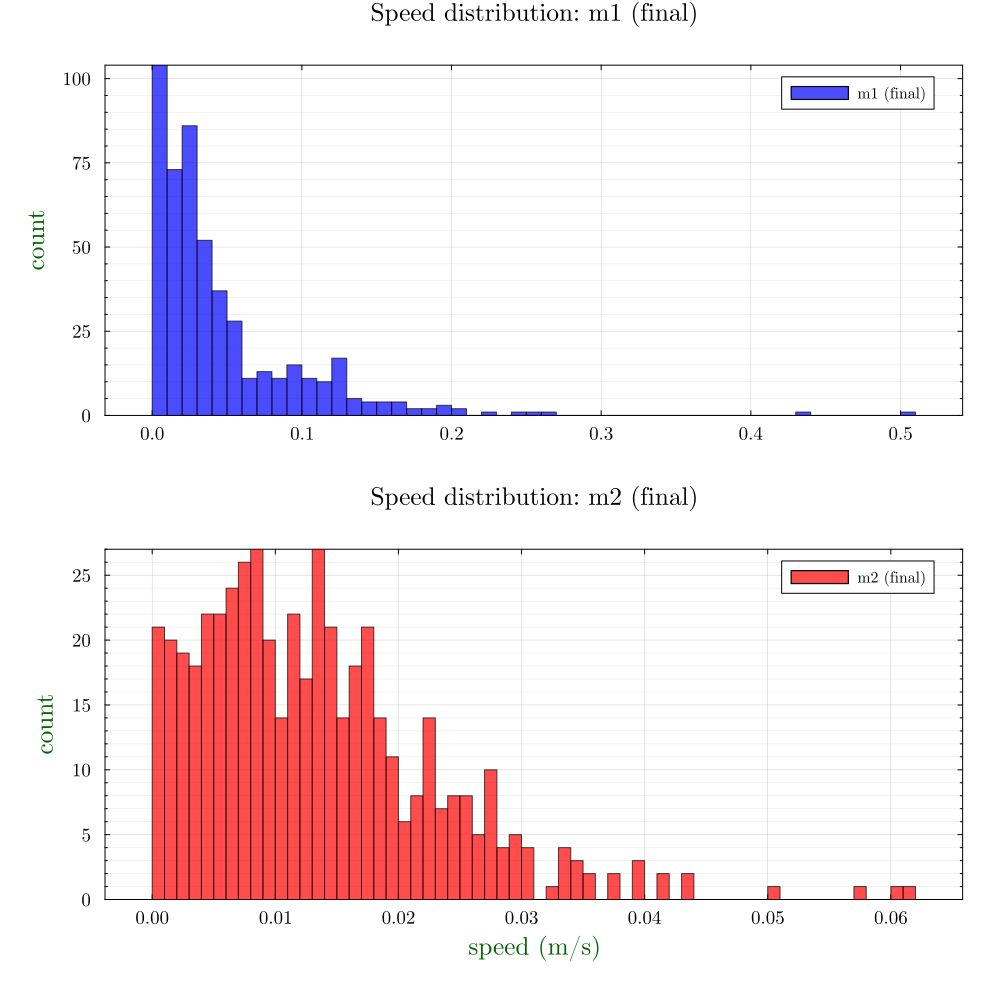

In [11]:
# Histogram of particle speeds separated by mass (final distributions)
# Two stacked histograms (2 rows, 1 column) with shared x-axis
if size(velocities, 2) >= 1
    n = length(particles)
    internal = 2:(n-1)  # internal particle indices
    idxs_m1 = [i for i in internal if isapprox(particles[i].m, m₁)]
    idxs_m2 = [i for i in internal if isapprox(particles[i].m, m₂)]

    if isempty(idxs_m1) || isempty(idxs_m2)
        println("No internal particles of one mass found; check m₁/m₂ settings.")
    else
        speeds_m1 = abs.(velocities[idxs_m1, end])
        speeds_m2 = abs.(velocities[idxs_m2, end])

        nbins = 50
        plt = plot(layout = (2,1), size=(1000,1000))

        histogram!(plt[1], speeds_m1, bins=nbins, alpha=0.7, color=:blue, label="m1 (final)")
        ylabel!(plt[1], "count")
        title!(plt[1], "Speed distribution: m1 (final)")

        histogram!(plt[2], speeds_m2, bins=2*nbins, alpha=0.7, color=:red, label="m2 (final)")
        xlabel!(plt[2], "speed (m/s)")
        ylabel!(plt[2], "count")
        title!(plt[2], "Speed distribution: m2 (final)")

        display(plt)
    end
else
    println("No recorded velocities available to plot histogram.")
end


In [14]:
# save the plot to a file
 savefig(plt, "1dBinaryGas_SpeedDistributions.png")

"/home/pauln/1DBinaryGas/src/1dBinaryGas_SpeedDistributions.png"

In [ ]:

# Plot trajectories (x vs t) for each particle
#plt = plot()
#for i in 1:n
#    plot!(plt, times, positions[i, :],label = "")
#end
#xlabel!(plt, "time (s)")
#ylabel!(plt, "x (m)")
#title!(plt, "Particle trajectories (event-driven)")
#display(plt)

# Optional: show final velocities
#println("\nFinal velocities:")
#for i in 1:n
#    println("p$(i-1): v=", round(particles[i].v, digits=6))
#end


In [ ]:
# Compute and compare total momentum: initial vs current
# Uses the recorded velocities (first column) as the initial state and
# the most recent recorded velocities (last column) and the current
# velocities stored in the `particles` array as two independent checks.
n = length(particles)
mvec = [particles[i].m for i in 1:n]

# initial momentum from the recorded velocities (column 1)
p_initial = sum(mvec .* velocities[:, 1])

# final momentum from the recorded velocities (last column)
p_final_record = sum(mvec .* velocities[:, end])

# final momentum computed directly from the particles array
p_final_particles = sum(mvec .* [p.v for p in particles])

Δp_record = p_final_record - p_initial
Δp_particles = p_final_particles - p_initial

println("Total momentum (initial)       = ", p_initial)
println("Total momentum (final, record)= ", p_final_record)
println("Total momentum (final, parts) = ", p_final_particles)

Total momentum (initial)       = 8.176816569135784e-5
Total momentum (final, record)= 8.176816559513078e-5
Total momentum (final, parts) = 8.176816559513078e-5

Δp (final_record - initial)   = -9.622706277634396e-14
Δp (final_parts  - initial)   = -9.622706277634396e-14

Relative Δp (record)  = 1.1768279496363093e-9
Relative Δp (parts)   = 1.1768279496363093e-9

Total momentum (final, record)= 8.176816559513078e-5
Total momentum (final, parts) = 8.176816559513078e-5

Δp (final_record - initial)   = -9.622706277634396e-14
Δp (final_parts  - initial)   = -9.622706277634396e-14

Relative Δp (record)  = 1.1768279496363093e-9
Relative Δp (parts)   = 1.1768279496363093e-9


┌ Warning: Total momentum changed significantly compared to initial value.
└ @ Main /home/pauln/1DBinaryGas/src/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sZmlsZQ==.jl:38
┌ Warning: Consider checking numerical tolerances, event ordering, or iteration caps.
└ @ Main /home/pauln/1DBinaryGas/src/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sZmlsZQ==.jl:39
